<h1 align="center">☁️ - Cloudy regions segmentation 👨‍💻🔬</h1>

<h2 align="center">Segmentation - Vanilla UNet in Pytorch</h2>
<p align="center">
   Thomas Bury, Afonso Alves, Daniel Staudegger<br>
</p>

## Introduction

There are several great notebooks to build on. For educational purposes, a nice way to learn about image segmentation is to use a [kernel starting from scratch](https://www.kaggle.com/code/dhananjay3/image-segmentation-from-scratch-in-pytorch), understand the architecture and then improve by borrowing other elements from other NBs.
Another pitfall to avoid while learning is to use high-level frameworks, convenient for prototyping but not for learning, as they may hide all the details

## Why instance segmentation?
Many deep network architectures are dedicated to classification. However, when localization is also required, we need a pixel-to-pixel identification and a label prediction. Here is the qualitative difference with other methods

![inst_seg](https://i.stack.imgur.com/MEB9F.png)

## Features of this NB
* Using the Unet Architecture
* Deterministic behaviour for reproducibility
* K-fold cross-validation 
* Implement the loss function for clarity, as done in the python package [segmentation_models.pytorch](https://github.com/qubvel/segmentation_models.pytorch)
* Investigation of the training process
* Processing output (removing the mask that occurs on the black part of the input image)
* Drawing convex hull before optimizing thresholds

## Unet architecture

U-net architecture (example for 32x32 pixels in the lowest resolution). Each blue box corresponds to a multi-channel feature map. The number of channels is denoted on top of the box. The x-y-size is provided at the lower left edge of the box. White boxes represent copied feature maps. The arrows denote the different operations. 

The architecture consists of a contracting path to capture
context and a symmetric expanding path that enables precise localization. Such a network outperforms the prior best method (a sliding-window
convolutional network) on medical images. One important feature in the UNet architecture is that in the upsampling part there is also a large number of feature channels, which allow the network to propagate context information to higher resolution layers. As a consequence, the expansive path is more or less symmetric to the contracting path, and yields a u-shaped architecture (hence the name).

 * The contracting path follows the scheme `conv_layer1 -> conv_layer2 -> max_pooling -> dropout(optional)`, meaning feature extraction, downsampling (feature selection/dim reduction) and regularization (dropout).
 * The bottom part is only convulotional steps, feature extraction
 * The expansive path follows the scheme `conv_2d_transpose -> concatenate -> conv_layer1 -> conv_layer2` Transposed convolution is an upsampling method that expands the size of images (set the value of a pixel from the kernel to n pixels of the target array). See [the visual explanation](https://naokishibuya.medium.com/up-sampling-with-transposed-convolution-9ae4f2df52d0).

Details in a [short video](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) made by the authors of [the original paper](https://arxiv.org/pdf/1505.04597.pdf)

![Unet](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

### **references**
1. https://www.kaggle.com/code/dhananjay3/image-segmentation-from-scratch-in-pytorch
2. https://www.kaggle.com/artgor/segmentation-in-pytorch-using-convenient-tools
3. https://www.kaggle.com/ryches/turbo-charging-andrew-s-pytorch
4. https://github.com/qubvel/segmentation_models.pytorch/blob/master/segmentation_models_pytorch/utils/losses.py
5. https://github.com/milesial/Pytorch-UNet
6. https://www.kaggle.com/ratthachat/cloud-convexhull-polygon-postprocessing-no-gpu
7. https://github.com/qubvel/segmentation_models.pytorch
8. https://github.com/albumentations-team/albumentations

In [ ]:
!pip uninstall pyreidolia

Found existing installation: pyreidolia 0.0.4
Uninstalling pyreidolia-0.0.4:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/pyreidolia-0.0.4.dist-info/*
    /usr/local/lib/python3.7/dist-packages/pyreidolia/*
Proceed (y/n)? y
  Successfully uninstalled pyreidolia-0.0.4


In [ ]:
!pip install -U git+https://github.com/ThomasBury/pyreidolia

# Imports

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

# ablumentations for easy image augmentation for input as well as output
import albumentations as albu
# from albumentations import torch as AT
from zipfile import ZipFile
import os
import gc
import cv2
import time
import tqdm
import random
import collections
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from functools import partial
import matplotlib.pyplot as plt
from tqdm.auto import tqdm as tq
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
import yaml
from pprint import pprint

# Custom package for the project, save all the functions into appropriate sub-packages
from pyreidolia.plot import (set_my_plt_style, 
                             plot_cloud, 
                             plot_rnd_cloud, 
                             draw_label_only, 
                             visualize_with_raw)
from pyreidolia.mask import (bounding_box, 
                             rle_to_mask, 
                             get_binary_mask_sum, 
                             mask_to_rle)
from pyreidolia.img import get_resolution_sharpness
from pyreidolia.processing import resize, draw_convex_hull, post_process

from pyreidolia.unet import UNet
from pyreidolia.optim import RAdam
from pyreidolia.io import get_img
from pyreidolia.segmentation import (seed_everything, 
                                     to_tensor, 
                                     CloudDataset, 
                                     get_training_augmentation, 
                                     get_validation_augmentation, 
                                     dice_no_threshold, 
                                     dice,
                                     BCEDiceLoss)

set_my_plt_style()

In [36]:
import scicomap as sc
import matplotlib as mpl
sc_map = sc.ScicoSequential(cmap='tropical')
sc_map.unif_sym_cmap(lift=None, 
                     bitonic=False, 
                     diffuse=True)
sc_cmap = sc_map.get_mpl_color_map()

mpl.cm.register_cmap("sc_tropical", sc_cmap)

In [ ]:
# with ZipFile('/content/test_images_525.zip', 'r') as zipObj:
#    # Extract all the contents of zip file in current directory
#    zipObj.extractall()

In [ ]:
# from google.colab import files
# uploaded = files.upload()

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive') #, force_remount=True)

In [3]:
# doc_path = "/content/drive/MyDrive/pyreidolia/train.csv"
# doc_clean_path = "/content/drive/MyDrive/pyreidolia/train_info_clean.csv"
# submission_path = "/content/drive/MyDrive/pyreidolia/sample_submission.csv"
# folder_path = "/content/drive/MyDrive/pyreidolia/"
# train_path =  "/content/drive/MyDrive/pyreidolia/train_images_525/"
# mask_path = "/content/drive/MyDrive/pyreidolia/train_masks_525/"
# test_path = "/content/drive/MyDrive/pyreidolia/test_images_525/"


doc_path = "/content/train.csv"
doc_clean_path = "/content/train_info_clean.csv"
submission_path = "/content/sample_submission.csv"
folder_path = "/content/"
train_path =  "/content/train_images_525/"
mask_path = "/content/train_masks_525/"
test_path = "/content/test_images_525/"

# Helper functions

In [4]:
# helper functions
class_names = ['Fish', 'Flower', 'Sugar', 'Gravel']

In [5]:
# sigmoid = lambda x: 1 / (1 + np.exp(-x))
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [ ]:
# Where is my yaml ? "C:/Users/xtbury/Documents/Projects/Pyreidolia/paths.yml"

# paths_yml = input("where is the paths.yml config file?")
# with open(paths_yml, "r") as ymlfile:
#     path_dic = yaml.load(ymlfile, Loader=yaml.FullLoader)

# pprint(path_dic)

In [6]:
# path = "../input/understanding_cloud_organization"
# img_paths = "../input/understanding-clouds-resized"
# os.listdir(path)
train_on_gpu = torch.cuda.is_available()
print(f"The model will be trained on GPU: {train_on_gpu}")
SEED = 42
MODEL_NO = 0 # in K-fold
N_FOLDS = 5 # in K-fold
seed_everything(SEED)

The model will be trained on GPU: True


## Make split in train validation and test sets

We can also filter out all the images with poor quality, usually having either a big black band or a bright band (or both).

In [7]:
train = pd.read_parquet('/content/train_info_clean.parquet')
train.shape

(22184, 10)

The sharpness threshold 23.00


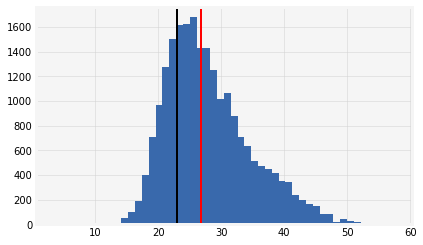

In [8]:
ax = train.sharpness.hist(bins=50)
ax.axvline(x=train.sharpness.median(), color='r');
ax.axvline(x=train.sharpness.quantile(.25), color='k');
print(f"The sharpness threshold {train.sharpness.quantile(.25):.2f}")

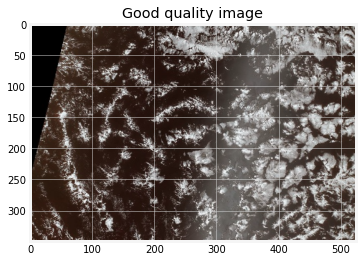

In [9]:
img_id_list = list(train.loc[train.sharpness >= 23.0, 'image_id'])
img = cv2.imread(train_path + img_id_list[0])
plt.title("Good quality image")
plt.imshow(img);

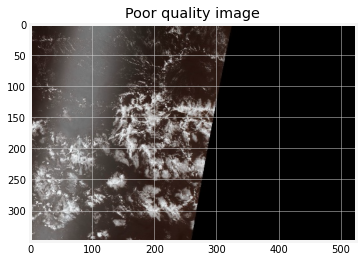

In [10]:
very_bad_img_id_list = list(train.loc[train.sharpness < 13.0, 'image_id'])
img = cv2.imread(train_path + very_bad_img_id_list[1])
plt.title("Poor quality image")
plt.imshow(img);

In [11]:
# read the original documentation
train = pd.read_csv('/content/train.zip')
train.shape

(22184, 2)

In [12]:
train["label"] = train["Image_Label"].apply(lambda x: x.split("_")[1])
train["im_id"] = train["Image_Label"].apply(lambda x: x.split("_")[0])

# only good images are used
train = train.loc[train["im_id"].isin(img_id_list), :]

sub = pd.read_csv(submission_path)
sub["label"] = sub["Image_Label"].apply(lambda x: x.split("_")[1])
sub["im_id"] = sub["Image_Label"].apply(lambda x: x.split("_")[0])

# split data using stratification on the number of mask in the pictures
# Take the first fold for training a model
# For cross-val, we could train on the other folds (but time consuming)
id_mask_count = (
    train.loc[train["EncodedPixels"].isnull() == False, "Image_Label"]
    .apply(lambda x: x.split("_")[0])
    .value_counts()
    .sort_index()
    .reset_index()
    .rename(columns={"index": "img_id", "Image_Label": "count"})
)
ids = id_mask_count["img_id"].values
li = [
    [train_index, test_index]
    for train_index, test_index in StratifiedKFold(
        n_splits=N_FOLDS, random_state=SEED, shuffle=True,
    ).split(ids, id_mask_count["count"])
]
train_ids, valid_ids = ids[li[MODEL_NO][0]], ids[li[MODEL_NO][1]]
test_ids = sub["Image_Label"].apply(lambda x: x.split("_")[0]).drop_duplicates().values

print(f"training set   {train_ids[:5]}.. with length {len(train_ids)}")
print(f"validation set {valid_ids[:5]}.. with length {len(valid_ids)}")
print(f"testing set    {test_ids[:5]}.. with length {len(test_ids)}")

training set   ['0011165.jpg' '006c5a6.jpg' '008233e.jpg' '008a5ff.jpg' '0091591.jpg'].. with length 3326
validation set ['003994e.jpg' '009e2f3.jpg' '0146ef3.jpg' '0153a8b.jpg' '0225687.jpg'].. with length 832
testing set    ['002f507.jpg' '0035ae9.jpg' '0038327.jpg' '004f759.jpg' '005ba08.jpg'].. with length 3698


## Define the data-loader
The data-loaders will push the images to the GPU while augmenting the data (new images) by performing transformations (rotation, crop, etc.)


In [13]:
# define dataset and dataloader
num_workers = 0 # to avoid any parallelization error, set this to 0
bs = 8
train_dataset = CloudDataset(
    df=train,
    datatype="train",
    img_ids=train_ids,
    img_dir=folder_path,
    subfolder = "train_images_525/",
    mask_subfolder = "train_masks_525/",
    transforms=get_training_augmentation(),
)
valid_dataset = CloudDataset(
    df=train,
    datatype="valid",
    img_ids=valid_ids,
    img_dir=folder_path,
    subfolder = "train_images_525/",
    mask_subfolder = "train_masks_525/",
    transforms=get_validation_augmentation(),
)

train_loader = DataLoader(
    train_dataset, batch_size=bs, shuffle=True, num_workers=num_workers
)
valid_loader = DataLoader(
    valid_dataset, batch_size=bs, shuffle=False, num_workers=num_workers
)

## Model definition and set up

In this first attempt, the native (vanilla) UNet architecture is used.

In [14]:
# one channel because images converted to grayscale
model = UNet(n_channels=3, n_classes=4).float()
if train_on_gpu:
    model.cuda()

In [15]:
model # print Model

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2

## Model set up
We define the 
* loss function (weighted average of thebinary cross-entropy and the dice coefficient)
* the optimizer: rectified Adam (less sensitive to the learning rate)
* update of the learning rate (for finer optimization, but takes longer)
* learning rate updater

In [16]:
criterion = BCEDiceLoss(eps=1.0, activation=None)
optimizer = RAdam(model.parameters(), lr = 0.005)
current_lr = [param_group['lr'] for param_group in optimizer.param_groups][0]
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, cooldown=2)

## Training loop
The usual training loop, without fancy add-ons

 - push to gpu
 - forward pass : compute the predicted outputs
 - compute the loss
 - backward propagation : compute the gradient of the loss w.r.t the models parameters
 - perform a step of parameters optimization

Evalutate on the validation set and iterate for several cycles (aka epochs). Save the best model. 

In [18]:
# number of epochs to train the model
n_epochs = 32
train_loss_list = []
valid_loss_list = []
dice_score_list = []
lr_rate_list = []
valid_loss_min = np.Inf # track change in validation loss
epoch_bar = tq(range(1, n_epochs+1))
for epoch in epoch_bar:
    epoch_bar.set_description(f"Epoch {epoch:<4}")
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    dice_score = 0.0
    ###################
    # train the model #
    ###################
    model.train()
    bar = tq(train_loader, postfix={"train_loss":0.0})
    batch_nbr = 0
    for data, target in bar:
        bar.set_description(f"Training on batch {batch_nbr:<4}")
        batch_nbr += 1
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        #print(loss)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        bar.set_postfix(ordered_dict={"train_loss":loss.item()})
    ######################    
    # validate the model #
    ######################
    model.eval()
    del data, target
    with torch.no_grad():
        bar = tq(valid_loader, postfix={"valid_loss":0.0, "dice_score":0.0}, desc='validation')
        for data, target in bar:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            dice_cof = dice_no_threshold(output.cpu(), target.cpu()).item()
            dice_score +=  dice_cof * data.size(0)
            bar.set_postfix(ordered_dict={"valid_loss":loss.item(), "dice_score":dice_cof})
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    dice_score = dice_score/len(valid_loader.dataset)
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    dice_score_list.append(dice_score)
    lr_rate_list.append([param_group['lr'] for param_group in optimizer.param_groups])
    
    # print training/validation statistics 
    print(f'Epoch: {epoch}  Training Loss: {train_loss:.6f}  Validation Loss: {valid_loss:.6f} Dice Score: {dice_score:.6f}')
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), folder_path + 'vanilla_unet_2.pt')
        valid_loss_min = valid_loss
    
    scheduler.step(valid_loss)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 1  Training Loss: 1.049433  Validation Loss: 1.166456 Dice Score: 0.357849
Validation loss decreased (inf --> 1.166456).  Saving model ...


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 2  Training Loss: 0.988856  Validation Loss: 1.006254 Dice Score: 0.396033
Validation loss decreased (1.166456 --> 1.006254).  Saving model ...


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 3  Training Loss: 0.978124  Validation Loss: 1.029080 Dice Score: 0.361383


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 4  Training Loss: 0.968833  Validation Loss: 1.024169 Dice Score: 0.420450


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 5  Training Loss: 0.958797  Validation Loss: 1.004812 Dice Score: 0.401615
Validation loss decreased (1.006254 --> 1.004812).  Saving model ...


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 6  Training Loss: 0.950931  Validation Loss: 1.125188 Dice Score: 0.390028


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 7  Training Loss: 0.940917  Validation Loss: 1.032436 Dice Score: 0.416028


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 8  Training Loss: 0.927604  Validation Loss: 1.029024 Dice Score: 0.398645


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 9  Training Loss: 0.904158  Validation Loss: 0.924862 Dice Score: 0.444217
Validation loss decreased (1.004812 --> 0.924862).  Saving model ...


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 10  Training Loss: 0.886481  Validation Loss: 0.880992 Dice Score: 0.471406
Validation loss decreased (0.924862 --> 0.880992).  Saving model ...


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 11  Training Loss: 0.885525  Validation Loss: 0.903476 Dice Score: 0.452930


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 12  Training Loss: 0.879743  Validation Loss: 0.872979 Dice Score: 0.481169
Validation loss decreased (0.880992 --> 0.872979).  Saving model ...


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 13  Training Loss: 0.880168  Validation Loss: 0.935935 Dice Score: 0.450193


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 14  Training Loss: 0.870942  Validation Loss: 0.933123 Dice Score: 0.442415


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 15  Training Loss: 0.867093  Validation Loss: 0.856661 Dice Score: 0.486425
Validation loss decreased (0.872979 --> 0.856661).  Saving model ...


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 16  Training Loss: 0.865852  Validation Loss: 0.855500 Dice Score: 0.484040
Validation loss decreased (0.856661 --> 0.855500).  Saving model ...


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 17  Training Loss: 0.861568  Validation Loss: 0.859371 Dice Score: 0.490248


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 18  Training Loss: 0.864087  Validation Loss: 0.893219 Dice Score: 0.461150


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 19  Training Loss: 0.858488  Validation Loss: 0.864546 Dice Score: 0.483194


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 20  Training Loss: 0.842218  Validation Loss: 0.836469 Dice Score: 0.496587
Validation loss decreased (0.855500 --> 0.836469).  Saving model ...


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 21  Training Loss: 0.847169  Validation Loss: 0.833623 Dice Score: 0.501438
Validation loss decreased (0.836469 --> 0.833623).  Saving model ...


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 22  Training Loss: 0.840115  Validation Loss: 0.834334 Dice Score: 0.502864


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 23  Training Loss: 0.842607  Validation Loss: 0.831103 Dice Score: 0.498666
Validation loss decreased (0.833623 --> 0.831103).  Saving model ...


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 24  Training Loss: 0.836845  Validation Loss: 0.833499 Dice Score: 0.498467


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 25  Training Loss: 0.835944  Validation Loss: 0.830635 Dice Score: 0.498841
Validation loss decreased (0.831103 --> 0.830635).  Saving model ...


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 26  Training Loss: 0.836605  Validation Loss: 0.831375 Dice Score: 0.500170


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 27  Training Loss: 0.833155  Validation Loss: 0.831172 Dice Score: 0.503510


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 28  Training Loss: 0.832174  Validation Loss: 0.833227 Dice Score: 0.500840


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 29  Training Loss: 0.829415  Validation Loss: 0.827503 Dice Score: 0.500275
Validation loss decreased (0.830635 --> 0.827503).  Saving model ...


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 30  Training Loss: 0.829950  Validation Loss: 0.825866 Dice Score: 0.501835
Validation loss decreased (0.827503 --> 0.825866).  Saving model ...


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 31  Training Loss: 0.826226  Validation Loss: 0.824752 Dice Score: 0.502867
Validation loss decreased (0.825866 --> 0.824752).  Saving model ...


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 32  Training Loss: 0.832083  Validation Loss: 0.826236 Dice Score: 0.501192


## Ploting Metrics

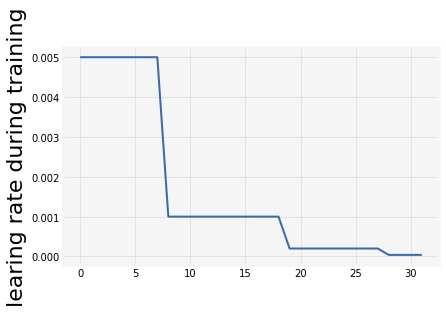

In [19]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot([i[0] for i in lr_rate_list])
ax.set_ylabel('learing rate during training', fontsize=22)
fig.savefig("learning_rate.png")

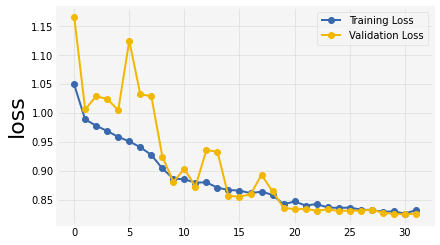

In [20]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(train_loss_list,  marker='o', label="Training Loss")
ax.plot(valid_loss_list,  marker='o', label="Validation Loss")
ax.set_ylabel('loss', fontsize=22)
ax.legend()
fig.savefig("loss.png")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


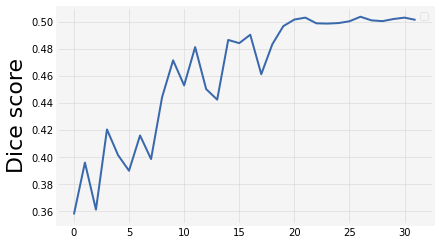

In [21]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(dice_score_list)
ax.set_ylabel('Dice score', fontsize=22)
ax.legend()
fig.savefig("dice_score.png")

In [22]:
# load best model
model.load_state_dict(torch.load(folder_path + 'vanilla_unet_2.pt'))
model.eval();

In [23]:
valid_masks = []
count = 0
tr = min(len(valid_ids)*4, 2000)
probabilities = np.zeros((tr, 350, 525), dtype = np.float32)
valid_bar = tq(valid_loader)
val_batch_nbr = 0
for data, target in valid_bar:
    valid_bar.set_description(f"Validating on batch nbr {val_batch_nbr:4}")
    val_batch_nbr += 1
    if train_on_gpu:
        data = data.cuda()
    target = target.cpu().detach().numpy()
    outpu = model(data).cpu().detach().numpy()
    for p in range(data.shape[0]):
        output, mask = outpu[p], target[p]
        for m in mask:
            valid_masks.append(resize(m))
        for probability in output:
            probabilities[count, :, :] = resize(probability)
            count += 1
        if count >= tr - 1:
            break
    if count >= tr - 1:
        break

  0%|          | 0/104 [00:00<?, ?it/s]

In [24]:
valid_masks = []
count = 0
tr = min(len(valid_ids)*4, 2000)
probabilities = np.zeros((tr, 350, 525), dtype = np.float32)
val_batch_nbr = 0
for data, target in valid_bar:
    valid_bar.set_description(f"Validating on batch nbr {val_batch_nbr:4}")
    val_batch_nbr += 1
    if train_on_gpu:
        data = data.cuda()
    target = target.cpu().detach().numpy()
    outpu = model(data).cpu().detach().numpy()
    for p in range(data.shape[0]):
        output, mask = outpu[p], target[p]
        for m in mask:
            valid_masks.append(resize(m))
        for probability in output:
            probabilities[count, :, :] = resize(probability)
            count += 1
        if count >= tr - 1:
            break
    if count >= tr - 1:
        break

## Grid Search for best Threshold
Try out several threshold for the probability, compute the loss and choose the best value (validation set)

In [25]:
class_params = {}
for class_id in range(4):
    print(class_id)
    attempts = []
    for t in range(0, 100, 5):
        t /= 100
        for ms in [0, 100, 1200, 5000, 10000, 30000]:
            masks, d = [], []
            for i in range(class_id, len(probabilities), 4):
                probability = probabilities[i]
                predict, num_predict = post_process(probability, t, ms)
                masks.append(predict)
            for i, j in zip(masks, valid_masks[class_id::4]):
                if (i.sum() == 0) & (j.sum() == 0):
                    d.append(1)
                else:
                    d.append(dice(i, j))
            attempts.append((t, ms, np.mean(d)))

    attempts_df = pd.DataFrame(attempts, columns=['threshold', 'size', 'dice'])
    attempts_df = attempts_df.sort_values('dice', ascending=False)
    print(attempts_df.head())
    best_threshold = attempts_df['threshold'].values[0]
    best_size = attempts_df['size'].values[0]
    class_params[class_id] = (best_threshold, best_size)

0
    threshold   size      dice
65       0.50  30000  0.593540
71       0.55  30000  0.589390
59       0.45  30000  0.585274
53       0.40  30000  0.579796
47       0.35  30000  0.579156
1
    threshold   size      dice
47       0.35  30000  0.756731
41       0.30  30000  0.752519
59       0.45  30000  0.752432
65       0.50  30000  0.751797
53       0.40  30000  0.750736
2
    threshold   size      dice
59       0.45  30000  0.564276
53       0.40  30000  0.564199
47       0.35  30000  0.561417
88       0.70  10000  0.558343
65       0.50  30000  0.556299
3
    threshold   size      dice
88       0.70  10000  0.573032
82       0.65  10000  0.567990
94       0.75  10000  0.564233
29       0.20  30000  0.560608
35       0.25  30000  0.556651


In [26]:
del masks
del valid_masks
del probabilities
gc.collect()

18821

In [27]:
attempts_df = pd.DataFrame(attempts, columns=['threshold', 'size', 'dice'])
print(class_params)

{0: (0.5, 30000), 1: (0.35, 30000), 2: (0.45, 30000), 3: (0.7, 10000)}


In [28]:
attempts_df.groupby(['threshold'])['dice'].max()

threshold
0.00    0.277845
0.05    0.448616
0.10    0.515600
0.15    0.547012
0.20    0.560608
0.25    0.556651
0.30    0.555724
0.35    0.546105
0.40    0.542719
0.45    0.551113
0.50    0.555746
0.55    0.555378
0.60    0.554334
0.65    0.567990
0.70    0.573032
0.75    0.564233
0.80    0.553066
0.85    0.516349
0.90    0.474815
0.95    0.386501
Name: dice, dtype: float64

In [29]:
attempts_df.groupby(['size'])['dice'].max()

size
0        0.503056
100      0.512860
1200     0.524442
5000     0.549123
10000    0.573032
30000    0.560608
Name: dice, dtype: float64

In [30]:
attempts_df = attempts_df.sort_values('dice', ascending=False)
attempts_df.head(10)

threshold   size      dice
88        0.70  10000  0.573032
82        0.65  10000  0.567990
94        0.75  10000  0.564233
29        0.20  30000  0.560608
35        0.25  30000  0.556651
64        0.50  10000  0.555746
41        0.30  30000  0.555724
70        0.55  10000  0.555378
76        0.60  10000  0.554334
100       0.80  10000  0.553066

In [31]:
attempts_df.to_csv("grid_search_thres_2.csv")

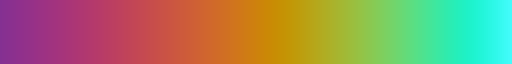

In [47]:
# sc_map = sc.ScicoQualitative(cmap='colorblind')
# sc_cmap = sc_map.get_mpl_color_map()
# mpl.cm.register_cmap("sc_cb", sc_cmap)
sc_cmap

In [34]:
attempts_df = pd.read_csv('grid_search_thres_2.csv', index_col=0)
attempts_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120 entries, 88 to 0
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   threshold  120 non-null    float64
 1   size       120 non-null    int64  
 2   dice       120 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 3.8 KB


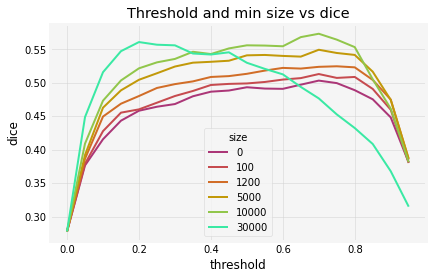

In [37]:
fig, ax = plt.subplots(figsize=(6, 4))
attempts_df['size'] = attempts_df['size'].astype("category")
ax = sns.lineplot(x='threshold', 
                   y='dice',
                   data=attempts_df, 
                   hue='size', 
                   palette='sc_tropical', 
                   ax=ax)
ax.set_title('Threshold and min size vs dice');
fig.savefig("gridsearch_thres_2.png")

In [38]:
best_threshold = attempts_df['threshold'].values[0]
best_size = attempts_df['size'].values[0]

## Predictions visualization
Qualitative visualization of the prediction: original image and mask, probabilities, thresholded probabilities and the convex hull of the detected regions.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

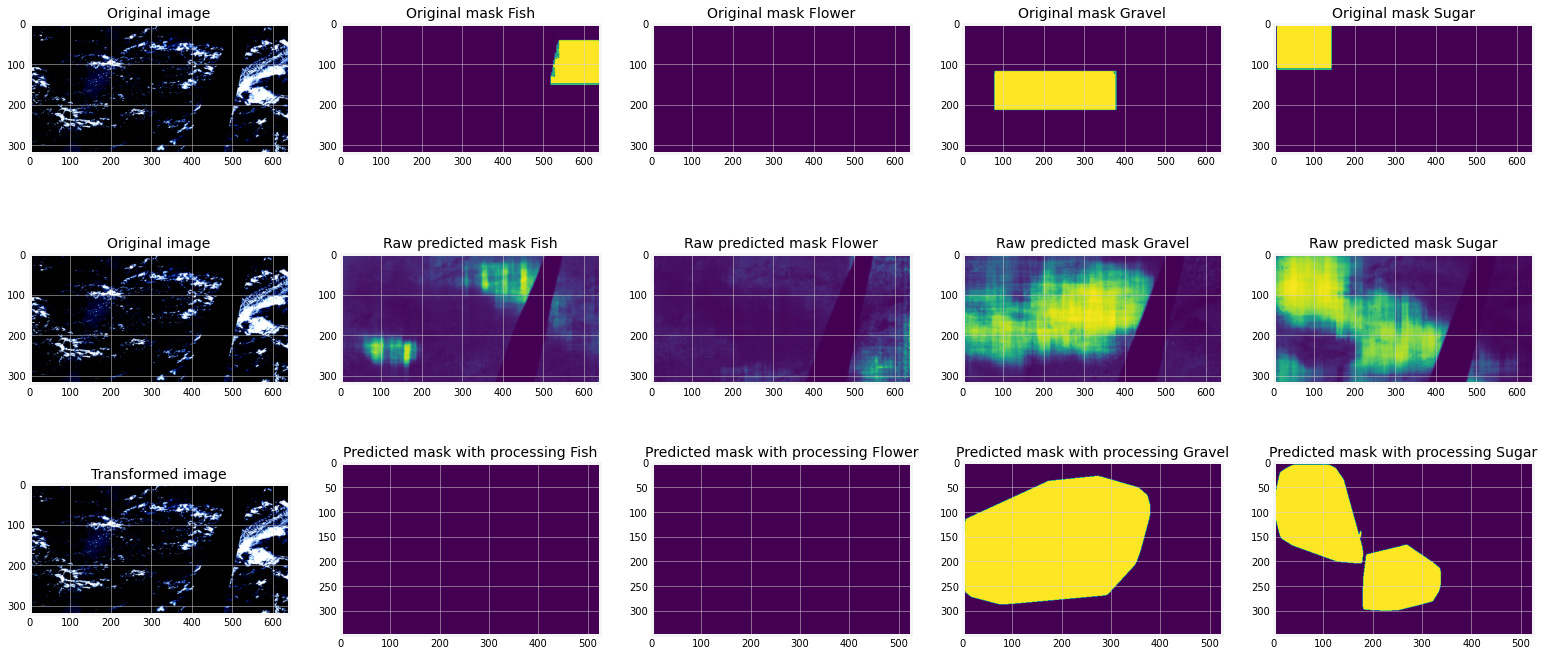

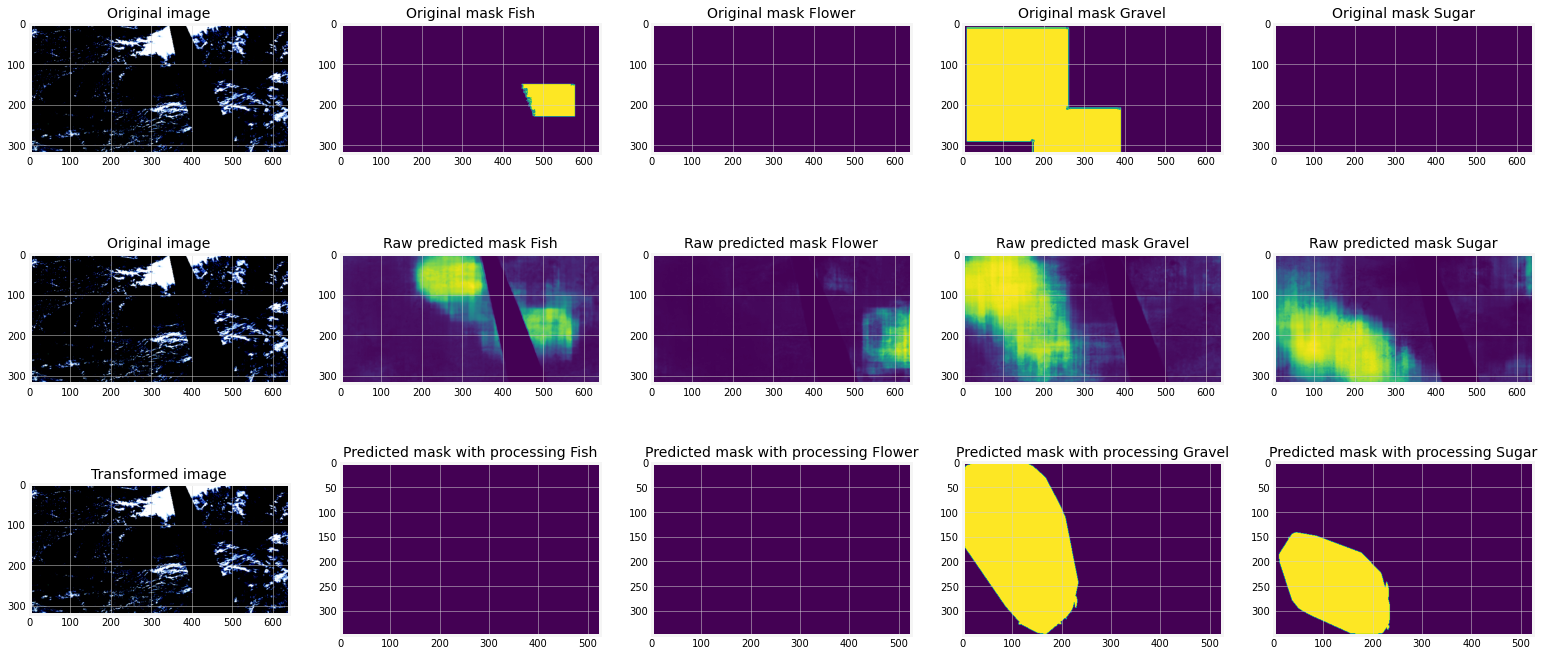

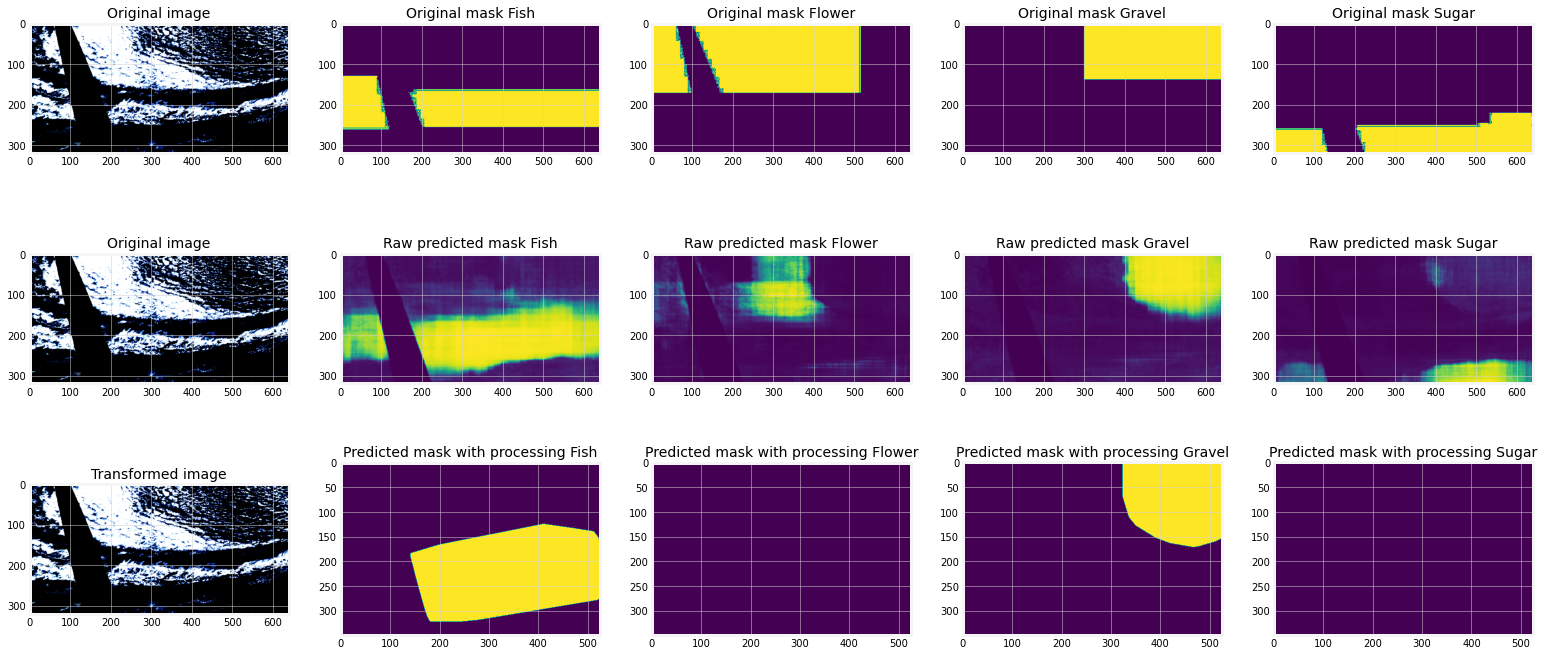

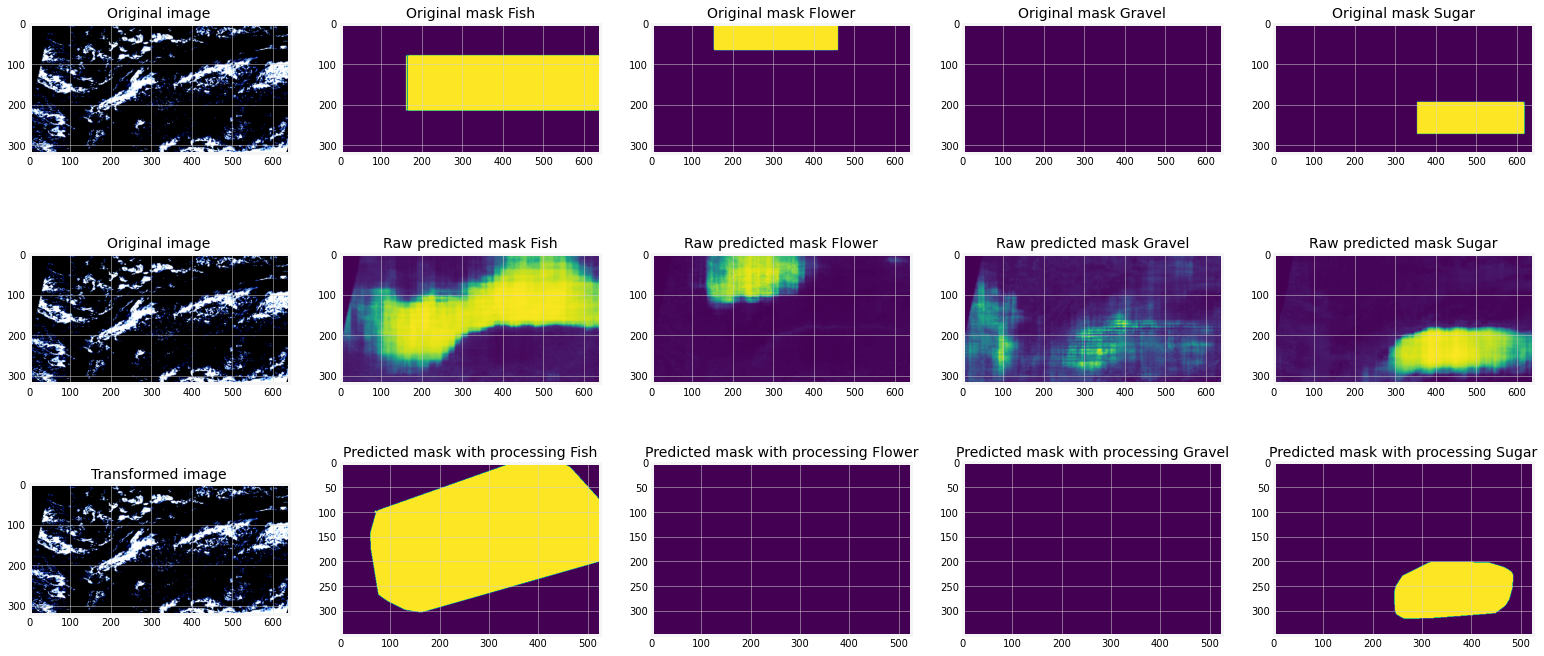

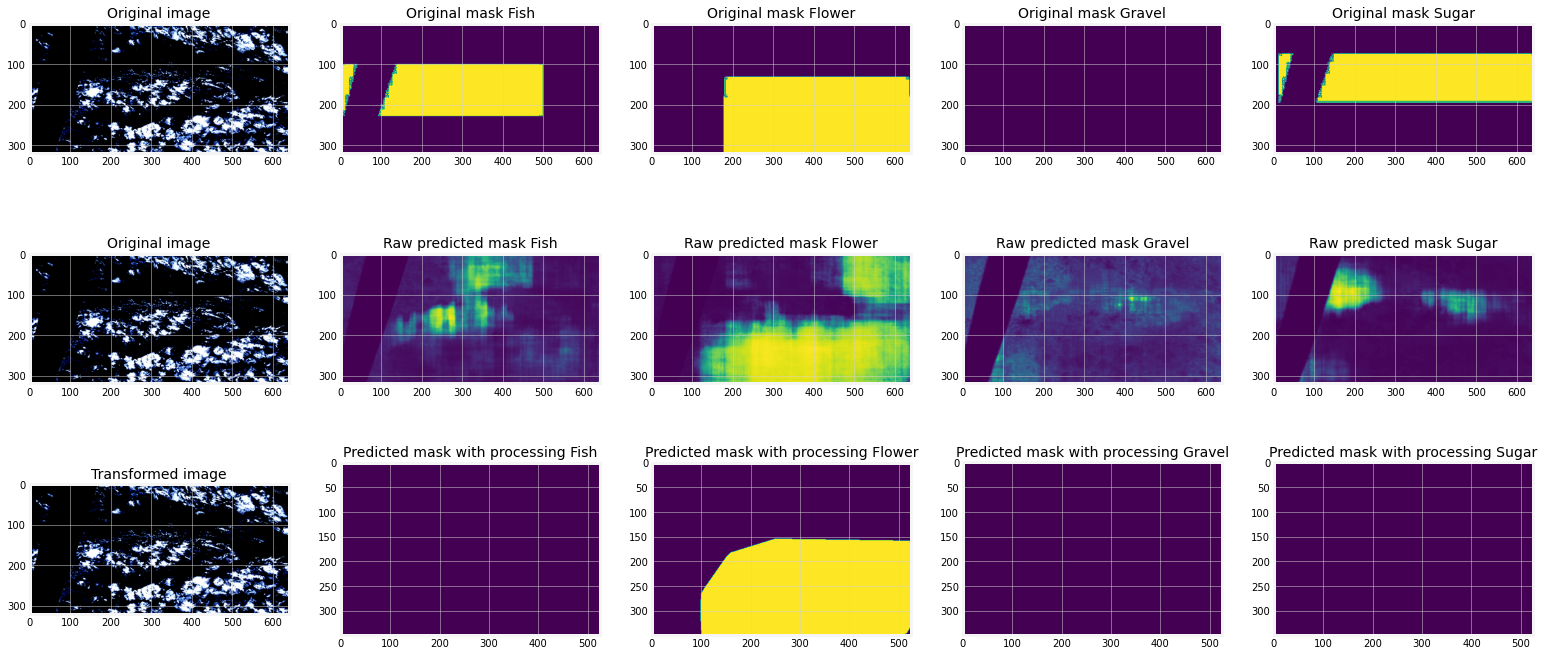

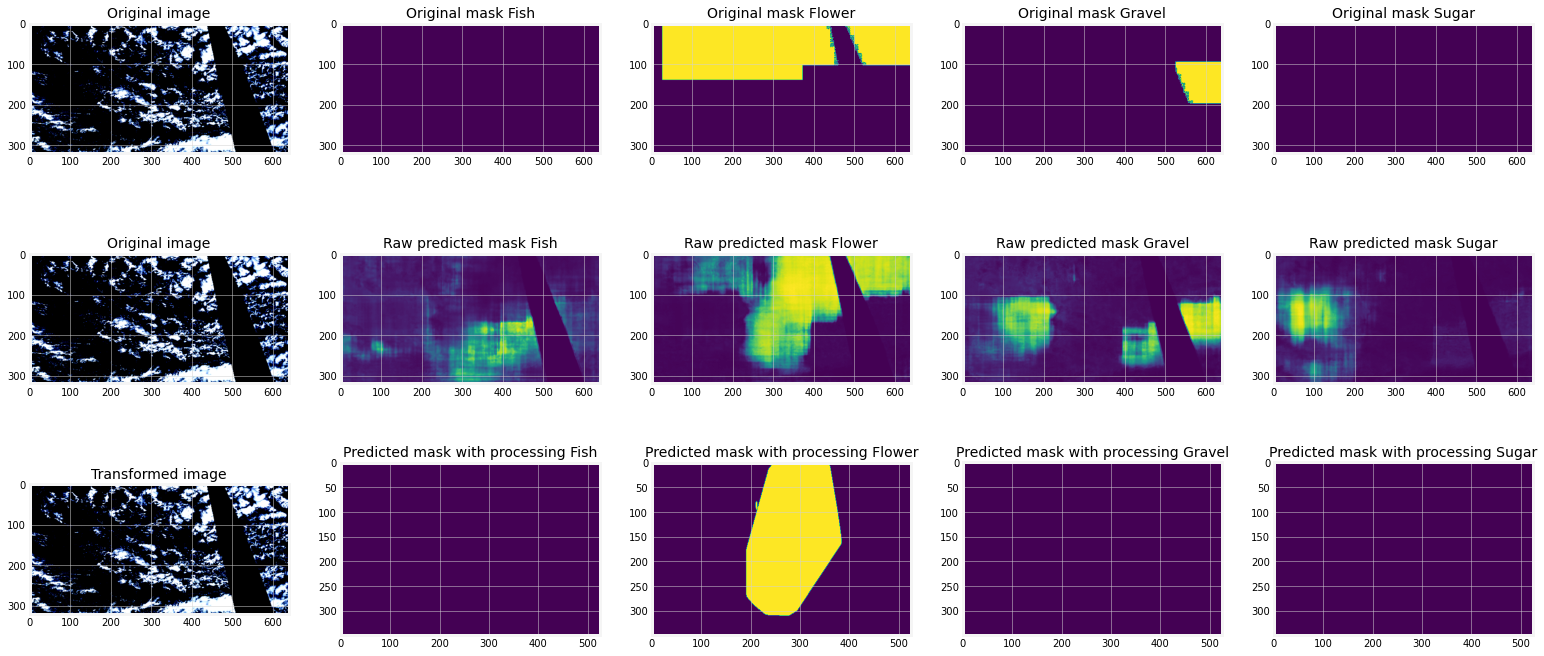

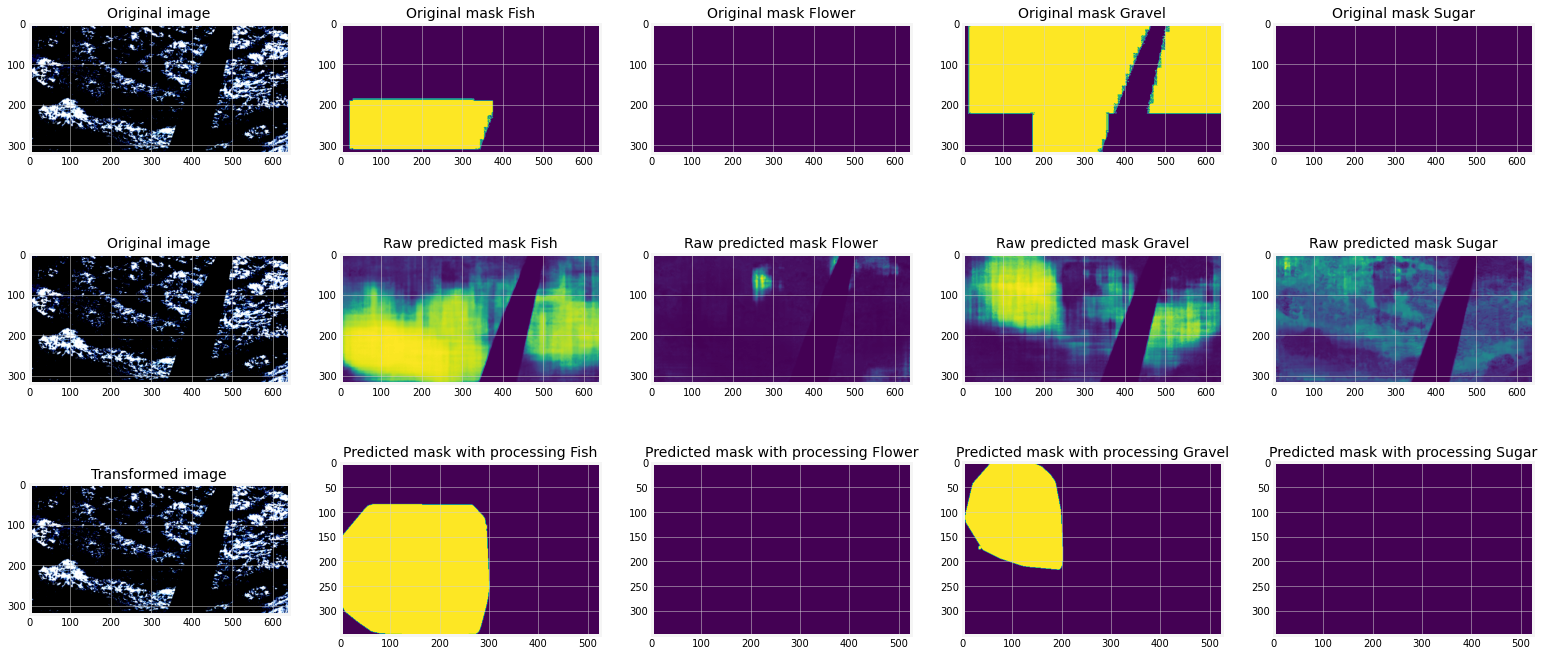

In [39]:
for i, (data, target) in enumerate(valid_loader):
    if train_on_gpu:
        data = data.cuda()
    output = ((model(data))[0]).cpu().detach().numpy()
    image  = data[0].cpu().detach().numpy()
    mask   = target[0].cpu().detach().numpy()
    output = output.transpose(1 ,2, 0)
    image_vis = image.transpose(1, 2, 0)
    mask = mask.astype('uint8').transpose(1, 2, 0)
    pr_mask = np.zeros((350, 525, 4))
    for j in range(4):
        probability = resize(output[:, :, j])
        pr_mask[:, :, j], _ = post_process(probability,
                                           class_params[j][0],
                                           class_params[j][1])
    visualize_with_raw(image=image_vis, mask=pr_mask,
                      original_image=image_vis, original_mask=mask,
                      raw_image=image_vis, raw_mask=output)
    plt.savefig("pred_with_raw_"+str(i)+".png")
    if i >= 6:
        break

In [40]:
torch.cuda.empty_cache()
gc.collect()

292891

In [41]:
test_dataset = CloudDataset(df=sub,
                            datatype='test', 
                            img_ids=test_ids,
                            img_dir=folder_path,
                            subfolder = "test_images_525/",
                            mask_subfolder = "train_masks_525/",
                            transforms=get_validation_augmentation())
test_loader = DataLoader(test_dataset, 
                         batch_size=4,
                         shuffle=False, 
                         num_workers=2)

In [42]:
del train_dataset, train_loader
del valid_dataset, valid_loader
gc.collect()

217

## Compute scores on the test set

In [43]:
subm = pd.read_csv(submission_path)
pathlist = [test_path + i.split("_")[0] for i in subm['Image_Label']]

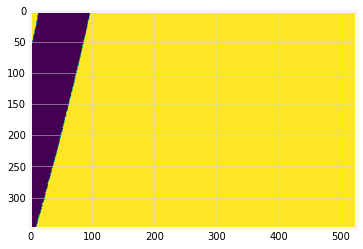

In [44]:
def get_black_mask(image_path):
    img = cv2.imread(image_path) 
    img = cv2.resize(img, dsize=tuple((525,350)), interpolation=cv2.INTER_LINEAR)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower = np.array([0, 0, 0], np.uint8)
    upper = np.array([180, 255, 10], np.uint8)
    return (~ (cv2.inRange(hsv, lower, upper) > 250)).astype(int)

plt.imshow(get_black_mask(pathlist[120]))
plt.show();

In [45]:
encoded_pixels = []
image_id = 0
cou = 0
np_saved = 0
for data, target in tq(test_loader):
    if train_on_gpu:
        data = data.cuda()
    output = model(data)
    del data
    for i, batch in enumerate(output):
        for probability in batch:
            probability = resize(probability.cpu().detach().numpy())
            predict, num_predict = post_process(probability,
                                                class_params[image_id % 4][0],
                                                class_params[image_id % 4][1])
            if num_predict == 0:
                encoded_pixels.append('')
            else:
                black_mask = get_black_mask(pathlist[cou])
                np_saved += np.sum(predict)
                predict = np.multiply(predict, black_mask)
                np_saved -= np.sum(predict)
                r = mask_to_rle(predict)
                encoded_pixels.append(r)
            cou += 1
            image_id += 1

print(f"number of pixel saved {np_saved}")

  0%|          | 0/925 [00:00<?, ?it/s]

number of pixel saved 416302.0


In [46]:
sub['EncodedPixels'] = encoded_pixels
sub.to_csv('unet_vanilla_pred_test_2.csv', columns=['Image_Label', 'EncodedPixels'], index=False)